### 读入数据，将out-of-samples生成图结构

In [9]:
from Mol2Graph import Mol2Graph
from rdkit.Chem import AllChem as Chem
import numpy as np

In [10]:
fr_out = eval(open('../density/split/2022_density_novel.table').read())

In [11]:
class DataFeat(object):
    def __init__(self, **kwargs):
        for k in kwargs:
            self.__dict__[k] = kwargs[k]
            
mol_block = eval(open('../density/split/density_molblocks_2022.dir').read())
def make_data(items):
    try:
        mol1 = Chem.MolFromMolBlock(mol_block[items[0]])
        mol2 = Chem.MolFromMolBlock(mol_block[items[1]])

        #mol1 = Chem.RemoveHs(mol1)  #这组是带H算的，去掉4个原子平均特征
        #mol2 = Chem.RemoveHs(mol2)
        g1 = Mol2Graph(mol1)
        g2 = Mol2Graph(mol2)
        x = np.concatenate([g1.x, g2.x], axis=0)
        edge_feats = np.concatenate([g1.edge_feats, g2.edge_feats], axis=0)
        e_idx2 = g2.edge_idx+g1.node_num
        edge_index = np.concatenate([g1.edge_idx, e_idx2], axis=0)
        return DataFeat(x=x, edge_feats=edge_feats, edge_index=edge_index, y=np.array([float(items[2])]))
    except: 
        print('Bad input sample:'+items[-1]+'skipped.')

In [12]:
from multiprocessing import Pool

pool = Pool(processes=30)                 # 创建进程池对象，进程数与multiprocessing.cpu_count()相同
data_pool_out = pool.map(make_data, [i for i in fr_out if Chem.MolFromMolBlock(mol_block[i[0]]) != None and Chem.MolFromMolBlock(mol_block[i[1]]) != None])
pool.close()
pool.join()

In [13]:
mean = 1.4773111506223011
std = 0.2657192556909069

In [14]:
Y_out = np.array([i.y for i in data_pool_out])

In [15]:
import torch
from torch_geometric.data import Data #, DataLoader
from torch_geometric.loader import DataLoader
from multiprocessing import Pool

In [16]:
loader_out = []
for d in data_pool_out:
    i = Data(x=torch.tensor(d.x),  #使用PyG 的Data来建图
         edge_index=torch.tensor(d.edge_index.T, dtype=torch.long),
         edge_attr=torch.tensor(d.edge_feats),
         y=torch.tensor((d.y-mean)/std, dtype=torch.float32))
    loader_out.append(i)

In [17]:
loader_out[0].x.shape

torch.Size([21, 39])

In [18]:
out_loader = DataLoader(loader_out, batch_size=128, shuffle=0)

In [19]:
for data in out_loader:
    print(data.num_graphs)
    print(data.keys)

128
['batch', 'x', 'y', 'edge_index', 'ptr', 'edge_attr']
128
['batch', 'x', 'y', 'edge_index', 'ptr', 'edge_attr']
16
['batch', 'x', 'y', 'edge_index', 'ptr', 'edge_attr']


#### Model

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import MessagePassing,  GraphNorm #GlobalAttention,
from torch_scatter import scatter

from torch_scatter import scatter_add
from torch_geometric.utils import softmax
import math

/PUBLIC/home/guojiali/anaconda3/envs/ccdc/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Conv(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim=6, aggr='add'):  #没有sum, 改成add
        super().__init__(aggr=aggr)  # "Add" aggregation (Step 5).
        self.aggr = aggr
        self.lin_neg = nn.Linear(in_channels+edge_dim, out_channels)  #+边的特征维度, nn.Linear是全连接层
        self.lin_root = nn.Linear(in_channels, out_channels)
        
    def forward(self, x, edge_index, edge_attr):
          
        x_adj = torch.cat([x[edge_index[1]],edge_attr], dim=1)   # 43+6=49
        #print('x_adj shape:',x_adj.shape)
        x_adj = F.tanh(self.lin_neg(x_adj))
        
        neg_sum = scatter(x_adj, edge_index[0], dim=0, reduce=self.aggr)  #散射填充
        
        x_out = F.tanh(self.lin_root(x)) + neg_sum
        #x_out = self.bn1(x_out)
        return x_out

In [3]:
"""
############### 自定义GlobalAttentaion 用于返回att###############
"""
from torch_scatter import scatter_add
from torch_geometric.utils import softmax

def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()
            
    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)

class GlobalAttention(torch.nn.Module):
    def __init__(self, gate_nn, nn=None):
        super().__init__()
        self.gate_nn = gate_nn
        self.nn = nn
        self.reset_parameters()
        
    def reset_parameters(self):
        reset(self.gate_nn)
        reset(self.nn)
    
    def forward(self, x, batch, size=None):
        x = x.unsqueeze(-1) if x.dim() == 1 else x
        size = batch[-1].item() + 1 if size is None else size
        
        gate = self.gate_nn(x).view(-1, 1)
        x = self.nn(x) if self.nn is not None else x
        assert gate.dim() == x.dim() and gate.size(0) == x.size(0)
        
        gate = softmax(gate, batch, num_nodes=size)
        out = scatter_add(gate * x, batch, dim=0, dim_size=size)
        
        return out, gate
    
    def __repr__(self) -> str:
        return(f'{self.__class__.__name__}(gate_nn={self.gate_nn}, '
               f'nn={self.nn})')
  

In [4]:
####重新寻参之后的参数
class CCGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv(39, 64)   #去H之后V的特征长度是39，之前是43
        self.gn1 = GraphNorm(64)
        self.conv2 = Conv(64, 16)
        self.gn2 = GraphNorm(16)
        #self.conv3 = MPconv(16, 128)
        #self.gn3 = GraphNorm(128)
        #self.conv4 = MPconv(128, 32)
        #self.gn4 = GraphNorm(32)
        
        #池化
        gate_nn = nn.Sequential(nn.Linear(16,64),
                                nn.ReLU(),
                                nn.Linear(64,32),
                                nn.ReLU(),
                                nn.Linear(32, 1))
        
        self.readout = GlobalAttention(gate_nn)
        self.lin1 = nn.Linear(16, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=0.5)
        self.lin2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dp2 = nn.Dropout(p=0.4)
        self.lin3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dp3 = nn.Dropout(p=0.25)
        self.lin = nn.Linear(128,1)
        
        
    def forward(self, data):
        
        x = self.conv1(data.x, data.edge_index, data.edge_attr)
        x = self.conv2(x, data.edge_index, data.edge_attr)
        #x = self.conv3(x, data.edge_index, data.edge_attr)
        #x = self.conv4(x, data.edge_index, data.edge_attr)
        
        embedding, att = self.readout(x, data.batch)
        #print('embedding shape',embedding.shape)
        
        out = self.dp1(self.bn1(F.relu(self.lin1(embedding)))) 
        out = self.dp2(self.bn2(F.relu(self.lin2(out)))) 
        out = self.dp3(self.bn3(F.relu(self.lin3(out))))
        out = self.lin(out)
        
        return out.view(-1), att

### 定义预测函数

In [5]:
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import r2_score
from scipy.stats import pearsonr   #除了统计r2以外，还要统计皮尔森相关系数的平方
import math

def predict(model, loader, device, mean, std):
    model.eval()
    error = 0
    loss_all = 0
    model_output = []
    y = []
    att_list = []
    for data in loader:
        data = data.to(device)
        output, att = model(data)
        
        error += (output * std - data.y * std).abs().sum().item()           #mae   # tensor.item() 只用在只有一个元素的tensor
                                                                                   # tensor.detach() 从原来的计算图的张量中返回一个新的张量，不需要梯度
        loss = F.mse_loss(torch.tensor([i*std+mean for i in output]), torch.tensor([i*std+mean for i in data.y]))   #z=(X-mean)/std为正太标准化的公式，这里反解之后求Loss
        loss_all += loss.item() * data.num_graphs                                                                           #   Returns a new Tensor, detached from the current graph. The result will never require gradient.
        print('data.num_graphs is ',data.num_graphs)
        model_output.extend(output.tolist())                                       # tensor.tolist() 从张量中返回一个python列表，对应的值与它相同
        y.extend(data.y.tolist())
        r2 = r2_score(y, model_output)
        pccs = pearsonr(y, model_output)[0]
        r2_pccs = pccs**2
        mse = loss_all/len(loader.dataset)
        rmse = math.sqrt(mse)
        mae = error/len(loader.dataset)
        att_list.extend(att.tolist())
    return rmse, mse, mae, r2, pccs, r2_pccs, model_output, y, att_list

### 先import model，再处理数据，最后用于预测
### 不然这里device可能由于import的冲突，会死掉

In [6]:
device = torch.device('cuda')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CCGNN().to(device)
model.load_state_dict(torch.load('./snapshot_Bayes_Opt/CD_GNN_Train_vs_test_removeH_edge_sorted/ModelParams.pkl'))

<All keys matched successfully>

In [20]:
rmse, mse, mae, r2, pccs, r2_pccs, model_output, y, att_list = predict(model, out_loader, device, mean, std)
print(rmse, mse, mae, r2, pccs, r2_pccs)

/PUBLIC/home/guojiali/anaconda3/envs/ccdc/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


data.num_graphs is  128
data.num_graphs is  128


/PUBLIC/home/guojiali/anaconda3/envs/ccdc/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/PUBLIC/home/guojiali/anaconda3/envs/ccdc/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


data.num_graphs is  16
0.042723095971238655 0.0018252629293676686 0.03487276022925096 0.9853426482659535 0.9927429187260456 0.985538502680708


In [22]:
all_Y = [y, model_output]

re_ = open('./snapshot_Bayes_Opt/CD_GNN_Train_vs_test_removeH_edge_sorted/out_of_samples_predy.table','w')
re_.write(str(all_Y))
re_.close()

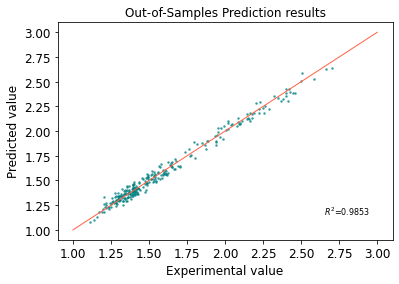

In [20]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np

#先将y值反解出来后作图
y_test = y
y_pred = model_output

mean = 1.4773111506223011
std = 0.2657192556909069

y_test = [i*std+mean for i in y_test]
y_pred = [i*std+mean for i in y_pred]

#tag = [i.split('b')[1] for i in lines[13].split('[')[1].split(']')[0].split(', ')]

line = [1, 3.0]
plt.figure()
plt.plot(line, line, linewidth=1, color='tomato')
plt.scatter(y_test, y_pred, s=10, color='teal', alpha=0.6, marker='.')
###用这个循环可以找到离群点的tag index，然后把想要标注的离群点单独画出来
#for i in range(len(y_test)):
    ##plt.annotate(tag[i], xy=(y_test[i], y_pred[i]), xytext=(y_test[i]+1, y_pred[i]+1))            #这个全部画出label看不清
    #plt.annotate(i, xy=(y_test[i], y_pred[i]), xytext=(y_test[i], y_pred[i]),fontsize=6)       #用这种方式，只显示index
#for i in [136]:  #单分子筛选溶剂和分子量后的，将离群点的坐标单独显示出来，另外保存
#    plt.annotate(tag[i], xy=(y_test[i], y_pred[i]), xytext=(y_test[i]+0.02, y_pred[i]+0.02),fontsize=6, fontweight='normal')
font = {'family':'Arial', 
        'style':'normal',  
        'weight':'medium',
        'size':12}
plt.title("Out-of-Samples Prediction results",fontdict=font)
plt.xlabel("Experimental value",size=12,family='Arial')
plt.ylabel("Predicted value",size=12,family='Arial')
plt.xticks(np.arange(1.0,3.1,0.25),size=12,family='Arial')
plt.yticks(np.arange(1.0,3.1,0.25),size=12,family='Arial')
plt.text(2.65, 1.15, '$R^2$=0.9853', fontsize=8) #530, 270,
#plt.legend('R2 = 0.756', loc='lower right')
plt.savefig('./snapshot_Bayes_Opt/CD_GNN_Train_vs_test_removeH_edge_sorted/best_model_53_out_of_samples.png',dpi=200)#_outlier

### 尝试给R2这里写入MAE和RMSE

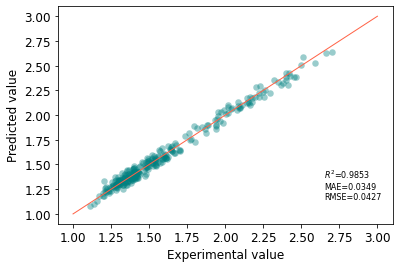

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np

#先将y值反解出来后作图
all_Y = eval(open('./snapshot_Bayes_Opt/CD_GNN_Train_vs_test_removeH_edge_sorted/out_of_samples_predy.table').read())
y_test = all_Y[0]
y_pred = all_Y[1]

#y_test = y
#y_pred = model_output

mean = 1.4773111506223011
std = 0.2657192556909069

y_test = [i*std+mean for i in y_test]
y_pred = [i*std+mean for i in y_pred]

#tag = [i.split('b')[1] for i in lines[13].split('[')[1].split(']')[0].split(', ')]

line = [1, 3.0]
plt.figure()
plt.plot(line, line, linewidth=1, color='tomato')
#plt.scatter(y_test, y_pred, s=10, color='teal', alpha=0.6, marker='.')
plt.scatter(y_test, y_pred, s=40, color='teal', alpha=0.4, marker='o',linewidths=0.1)
###用这个循环可以找到离群点的tag index，然后把想要标注的离群点单独画出来
#for i in range(len(y_test)):
    ##plt.annotate(tag[i], xy=(y_test[i], y_pred[i]), xytext=(y_test[i]+1, y_pred[i]+1))            #这个全部画出label看不清
    #plt.annotate(i, xy=(y_test[i], y_pred[i]), xytext=(y_test[i], y_pred[i]),fontsize=6)       #用这种方式，只显示index
#for i in [136]:  #单分子筛选溶剂和分子量后的，将离群点的坐标单独显示出来，另外保存
#    plt.annotate(tag[i], xy=(y_test[i], y_pred[i]), xytext=(y_test[i]+0.02, y_pred[i]+0.02),fontsize=6, fontweight='normal')
font = {'family':'Arial', 
        'style':'normal',  
        'weight':'medium',
        'size':12}
#plt.title("Out-of-Samples Prediction results",fontdict=font)
plt.xlabel("Experimental value",size=12,family='Arial')
plt.ylabel("Predicted value",size=12,family='Arial')
plt.xticks(np.arange(1.0,3.1,0.25),size=12,family='Arial')
plt.yticks(np.arange(1.0,3.1,0.25),size=12,family='Arial')
plt.text(2.65, 1.15, '$R^2$=0.9853\nMAE=0.0349\nRMSE=0.0427', fontsize=8) #530, 270,
#plt.legend('R2 = 0.756', loc='lower right')
plt.savefig('./snapshot_Bayes_Opt/CD_GNN_Train_vs_test_removeH_edge_sorted/best_model_53_out_of_samples_MAE_RMSE_s40.png',dpi=300)#_outlier

### 统计5%预测相对误差的数量

In [25]:
re_error = []
re_error_5 = []

for i in range(len(y_test)):
    error = ((y_pred[i]-y_test[i])/y_test[i])*100
    re_error.append(error)
    if abs(error) <= 5:
        re_error_5.append(error)
print('length re_error: ',len(re_error))
print('length re_error_5: ',len(re_error_5))
ratio_5 = len(re_error_5)/len(re_error)
print('The number of relative error less than 5% is ',ratio_5)

length re_error:  272
length re_error_5:  256
The number of relative error less than 5% is  0.9411764705882353


### 统计6%预测相对误差的数量

In [26]:
re_error = []
re_error_6 = []

for i in range(len(y_test)):
    error = ((y_pred[i]-y_test[i])/y_test[i])*100
    re_error.append(error)
    if abs(error) <= 6:
        re_error_6.append(error)
print('length re_error: ',len(re_error))
print('length re_error_6: ',len(re_error_6))
ratio_6 = len(re_error_6)/len(re_error)
print('The number of relative error less than 6% is ',ratio_6)

length re_error:  272
length re_error_6:  264
The number of relative error less than 6% is  0.9705882352941176


### 把真实值预测值，以及对应的error保存起来
### 放在补充材料里面

In [4]:
fr_out = eval(open('../density/split/2022_density_novel.table').read())

tag = []
for item in fr_out:
    tag.append(item[3])

In [12]:
import pandas as pd

re_error = []
Error = []

pred_3f = []
exp_3f = []
for i in range(len(y_test)):
    pred = float('%.3f'%y_pred[i])
    exp = float('%.3f'%y_test[i])
    pred_3f.append(pred)
    exp_3f.append(exp)
    error = float('%.3f'%(((pred-exp)/exp)*100))
    re_error.append(error)
    Error.append(float('%.3f'%(pred-exp)))
    
print('length re_error: ',len(re_error))
print('length tag: ',len(tag))

df = pd.DataFrame([tag, exp_3f, pred_3f, Error, re_error], index=['Refcode','Experimental D','Predictied D','Error', 're%'])
df_T = df.T
print(df_T.shape)
df_T[:5]

length re_error:  272
length tag:  272
(272, 5)


,Refcode,Experimental D,Predictied D,Error,re%
0,GUYYIL01,1.517,1.594,0.077,5.076
1,OJOCOI,1.29,1.267,-0.023,-1.783
2,AQUMIL,1.293,1.341,0.048,3.712
3,UWEYED,1.589,1.567,-0.022,-1.385
4,KAJSIB,1.263,1.294,0.031,2.454


In [13]:
df_T.to_csv('./snapshot_Bayes_Opt/CD_GNN_Train_vs_test_removeH_edge_sorted/out_of_samples_error.csv')

In [11]:
float('%.3f'%y_test[0])

1.517

In [10]:
y_test[0]

1.517000000498751

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


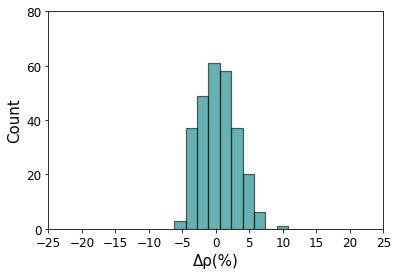

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

fig = plt.figure()
plt.hist(re_error, 
         bins = 10, 
         color = 'teal', #颜色网址https://zhuanlan.zhihu.com/p/65220518
         edgecolor = 'black',
         lw=1.2,
         alpha = 0.6) #
#sns.kdeplot(re_error, bw=0.25)
font = {'family':'Arial', 
        'style':'normal',  
        'weight':'medium',
        'size':12}
#plt.title("Re% ",fontdict=font)
plt.xlim(-25,25)
plt.xlabel('Δρ(%)',size=15,family='Arial')
plt.ylabel('Count', size=15,family='Arial')
plt.xticks(np.arange(-25,25.1,5),fontsize=12,family='Arial')
plt.yticks(np.arange(0,80.1,20),fontsize=12,family='Arial')
plt.savefig('./snapshot_Bayes_Opt/CD_GNN_Train_vs_test_removeH_edge_sorted/best_model_53_re_out_of_samples_error_hist',dpi=200)

#### 可视化注意力系数

In [1]:
len(att_list)

NameError: name 'att_list' is not defined

In [24]:
re = open('./snapshot_Bayes_Opt/CD_GNN_Train_vs_test_removeH_edge_sorted/out_of_samples_att.table','w')
re.write(str(att_list))
re.close()

In [ ]:
#att_list = eval(open('./snapshot_Bayes_Opt/CD_GNN_Train_vs_test_removeH_edge_sorted/out_of_samples_att.table').read())

In [25]:
class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__

In [26]:
from Featurize_G.Coformer import Coformer

def get_info(cc_table_dir):
    try:
        cc_dic = {}
        for items in eval(open(cc_table_dir).read()):
            cc_dic.setdefault(items[-1], items)
    except:
        cc_dic = {}
        for line in open(cc_table_dir).readlines():
            items = line.strip().split('\t')
            cc_dic.setdefault(items[-1], items)
    return cc_dic

cc_dic = get_info('../density/split/2022_density_novel.table')
mol_blocks = eval(open('../density/split/density_molblocks_2022.dir').read())
counter = 0
info = {}
#tags = ['dm17287', 'dm17287_exc']
for i in cc_dic.keys():
    info.setdefault(i, {})
    info[i]['coformers'] = [cc_dic[i][0], cc_dic[i][1]]
    c1 = mol_blocks[cc_dic[i][0]]
    c2 = mol_blocks[cc_dic[i][1]]
    c1 = Coformer(c1)
    c2 = Coformer(c2)
    n1, n2 = c1.atom_number, c2.atom_number
    info[i]['atom_number'] = [c1.atom_number, c2.atom_number]
    info[i]['c1'] = c1
    info[i]['c2'] = c2
    info[i]['attentions'] = att_list[counter:counter+n1+n2]
    counter = counter + n1+n2

In [27]:
info

{'GUYYIL01': {'coformers': ['OC(=O)c1ccc(cc1N(=O)=O)N(=O)=O_GUYYIL01',
   'CN(C)C(N)=O_GUYYIL01'],
  'atom_number': [15, 6],
  'c1': <Featurize_G.Coformer.Coformer at 0x7f711d505190>,
  'c2': <Featurize_G.Coformer.Coformer at 0x7f711d488390>,
  'attentions': [[0.06389066576957703],
   [0.05654170736670494],
   [0.027554458007216454],
   [0.027618777006864548],
   [0.06830538809299469],
   [0.0342501699924469],
   [0.03510480746626854],
   [0.028429292142391205],
   [0.028825733810663223],
   [0.04164270684123039],
   [0.04702923074364662],
   [0.06830538809299469],
   [0.052609749138355255],
   [0.04709864780306816],
   [0.052609749138355255],
   [0.06390464305877686],
   [0.047931969165802],
   [0.051075760275125504],
   [0.030766071751713753],
   [0.06325255334377289],
   [0.06325255334377289]]},
 'OJOCOI': {'coformers': ['Cc1cc(cc(C)c1N)c1cc(C)c(N)c(C)c1_OJOCOI',
   'N#Cc1cc(C#N)c(cc1C#N)C#N_OJOCOI'],
  'atom_number': [18, 14],
  'c1': <Featurize_G.Coformer.Coformer at 0x7f711d4bef5

In [2]:
from rdkit.Chem import AllChem as Chem
import numpy as np
from MapAttention import HighlightAtomByWeights, CombineImage

save_dir = '../density/split/cd_out_samples_vis_att_removeH_edge_sorted'
att_info = Dict(info)
removeHs = False #本来在读入数据的时候没有考虑H,rd_mol是没H的

for tag in att_info:
    n1, n2 = att_info[tag]['atom_number']
    w = att_info[tag]['attentions']
    w = [i[0] for i in w]
    
    if removeHs:
        c1_ = Chem.RemoveHs(att_info[tag]['c1'].rd_mol)
        heavy_idx1 = [i.GetIdx() for i in c1_.GetAtoms() if i.GetSymbol()!='H']
        c2_ = Chem.RemoveHs(att_info[tag]['c2'].rd_mol)
        heavy_idx2 = [i.GetIdx() for i in c2_.GetAtoms() if i.GetSymbol()!='H']
        w1 = np.array(w[:n1])[heavy_idx1]
        w2 = np.array(w[n1:])[heavy_idx2]
    else:
        c1_ = att_info[tag]['c1'].rd_mol
        c2_ = att_info[tag]['c2'].rd_mol
        w1 = np.array(w[:n1])
        w2 = np.array(w[n1:])
    save_name1 = '{}/coformers/{}-1.png'.format(save_dir, tag)
    save_name2 = '{}/coformers/{}-2.png'.format(save_dir, tag)
    w1 = w1/w1.sum()
    w2 = w2/w2.sum()
    draw1 = HighlightAtomByWeights(c1_, w1, save=save_name1, size=(400,400))#, atom_label_size=1)
    draw2 = HighlightAtomByWeights(c2_, w2, save=save_name2, size=(400,400))#, atom_label_size=1)
    CombineImage([save_name1,save_name2], title=tag, save_dir='{}/'.format(save_dir))

NameError: name 'Dict' is not defined

In [29]:
import operator

y_test = y
y_pred = model_output

mean = 1.4773111506223011
std = 0.2657192556909069

y_test = [i*std+mean for i in y_test]
y_pred = [i*std+mean for i in y_pred]

####统计误差从小到大
re_error_dict = dict()
tags = list(cc_dic.keys())

for i in range(len(y_test)):
    error = ((y_pred[i]-y_test[i])/y_test[i])*100
    re_error_dict[tags[i]]=abs(error)

re_error_dict = dict(sorted(re_error_dict.items(), key=operator.itemgetter(1))) #按照value值升序
print(len(re_error_dict))

272


In [30]:
re_error_dict

{'OSELIK': 0.004570401306537592,
 'EQEJIW': 0.021133185995358173,
 'OCOJAV': 0.041622429350464604,
 'UROTIH': 0.043779641950900915,
 'OKUROE': 0.04834912147298928,
 'OZEBON': 0.0636507036220059,
 'UXASAQ': 0.0641246790648855,
 'OZEDEF': 0.06445294844942875,
 'OMACAJ': 0.07531863089048524,
 'UKEXUG': 0.0856219716373115,
 'UKEXOA': 0.0907566737986832,
 'JUVFOY': 0.09242643880500168,
 'EJOBEN': 0.11614278794381064,
 'VAHROP': 0.14436042304023378,
 'AWUPIU01': 0.15825093614296706,
 'IZAHEZ': 0.19491347991069058,
 'APUWOA': 0.20908960025082063,
 'COBBAW': 0.21542691226426014,
 'OZEDOP': 0.25010903592462724,
 'ATAHIP': 0.2616738702743435,
 'IJUJIJ': 0.26288282767344573,
 'ITOCUS': 0.263941129459162,
 'RADYAA': 0.2675766244369548,
 'ITODON': 0.2919322546520031,
 'UWEGEL': 0.30009848487507756,
 'IPALIX': 0.3197805224151892,
 'EQOBOE': 0.3348690719820158,
 'HAMNAO': 0.3525120231483515,
 'OZEFOR': 0.3706072228509749,
 'EQEJOC': 0.3774937643577291,
 'IMOREK': 0.3806895461070817,
 'ESEZAG': 0.4028